# Dimensionality Reduction with Entropy

In this tutorial we consider the problem of reducing the number of features in a data set by selecting the most _informative_ features with respect to the target.

In [12]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 10)

We will be working with the [Mushroom Data Set](https://archive.ics.uci.edu/ml/datasets/mushroom).

1. Number of Instances: 8124

2. Number of Attributes: 22 (all nominally valued)

3. Attribute Information: (classes: edible=e, poisonous=p)
     1. cap-shape:                bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
     2. cap-surface:              fibrous=f,grooves=g,scaly=y,smooth=s
     3. cap-color:                brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
     4. bruises?:                 bruises=t,no=f
     5. odor:                     almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s
     6. gill-attachment:          attached=a,descending=d,free=f,notched=n
     7. gill-spacing:             close=c,crowded=w,distant=d
     8. gill-size:                broad=b,narrow=n
     9. gill-color:            black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
    10. stalk-shape:              enlarging=e,tapering=t
    11. stalk-root:               bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?
    12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
    13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
    14. stalk-color-above-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
    15. stalk-color-below-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
    16. veil-type:                partial=p,universal=u
    17. veil-color:               brown=n,orange=o,white=w,yellow=y
    18. ring-number:              none=n,one=o,two=t
    19. ring-type:                cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
    20. spore-print-color:        black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
    21. population:               abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
    22. habitat:                  grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

4. Missing Attribute Values: 2480 of them (denoted by "?"), all for
   attribute #11.

5. Class Distribution: 
    --    edible: 4208 (51.8%)
    -- poisonous: 3916 (48.2%)
    --     total: 8124 instances

In [13]:
data = pd.read_csv('data/agaricus-lepiota.data')
# Missing values in the data set are marked as '?'
data = data.replace('?', np.NaN)
data = data.dropna()

In [14]:
features = data.iloc[:, 1:]
labels = data.iloc[:, 0]

# Very crude and inefficient way to convert to numeric data.
# Will do for the purposes of this tutorial.
vord = np.vectorize(ord)
features = features.apply(vord)
labels = labels.apply(vord)

One way to measure how informative a feature is with respect to the target is to measure how well the feature segments the data.

For example, consider the following data

| Color             | Shape         | Target  |
| ------------------|:-------------:| -----:|
| Green             | Square        | 2 |
| Red               | Circle        | 1 |
| Red               | Triangle      | 1 |
| Green             | Triangle      | 2 |
| Green             | Circle        | 2 |
| Red               | Square        | 1 |

Let's sort our data by _Color_ to understand how informative the feature is of _Target_.

| Color             | Shape         | Target  |
| ------------------|:-------------:| -----:|
| Red               | Circle        | 1 |
| Red               | Triangle      | 1 |
| Red               | Square        | 1 |
| Green             | Triangle      | 2 |
| Green             | Square        | 2 |
| Green             | Circle        | 2 |

We can see that all the _Red_ samples have _Target_ value of 1, while all the _Green_ samples have _Target_ value of 2. In other words, _Color_ perfectly describes our _Target_. 
Let's compare this to the purity of the data sorted by _Shape._

| Color             | Shape         | Target  |
| ------------------|:-------------:| -----:|
| Red               | Circle        | 1 |
| Green             | Circle        | 2 |
| Red               | Triangle      | 1 |
| Green             | Triangle      | 2 |
| Green             | Square        | 2 |
| Red               | Square        | 1 |

Notice that all three geometric shapes may have a _Target_ value of 1 or 2. Thus, in some sense, _Color_ carries more information about _Target_ than _Shape_ does. 

We introduce the first building block towards formalizing the notion of feature informativeness.

## Entropy

__Entropy__ is a measure of chaos. It tells us how much information a _set_ $S$ carries. It is calculated using the following formula $$E(S) = -\sum_{i \in S} p_{i}\log(p_{i})$$ where $p_{i}$ is the proportion of the $i$-th entry in $S.$

To get some intuition how entropy works, consider a perfectly pure array $A = [1, 1, 1].$ Then $p_{1} = 1$ and $\log p_{1} = 0.$ So the entropy of $A$ is $0.$ This is consistent with the fact that despite the size of $A$, it carries very little information - just a single value of 1.

To contrast, let's consider an impure array $B = [1, 2, 3].$ Then $p_{i} = 1/3$ for $i \in \{1, 2, 3\}$ and $\log (1/3) = -1.58.$ So the entropy of $B$ is $4.74.$ This result is consistent with the fact that $B$ carries more information than $A$.

In [15]:
@np.vectorize
def log2(x):
    """Compute the base 2 logarithm of `x`."""
    log_x = np.log(x) / np.log(2)
    return log_x

def entropy(array):
    # Special case for an array of length 0
    if len(array) == 0:
        return 0
    
    probs = {}
    for elem in array:
        if elem in probs:
            probs[elem] += 1 / len(array)
        else:
            probs[elem] = 1 / len(array)
            
    entropy = -np.sum(probs[elem] * log2(probs[elem]) for elem in probs)
    
    return entropy

In [16]:
entropy(labels)

0.9593652915824233

## Information Gain

Having defined a measure of purity of data, we now formalize what we mean when we say a that a feature carries information about a target. As we saw in the example above, __when a feature carries information about a target, splitting the data into groups based on this feature produces smaller sets of data that are more pure than the parent data set.__

We formalize this notion by defining __Information Gain to be the difference between the entropy of the original data set and the weighted sum of the entropies of the groups.__

In [17]:
def get_groups(df, targets, feature):
    """Build  target groups by splitting `targets` according to the values of `feature`."""
    values = df[feature].unique()
    groups = []
    for value in values:
        group = targets[df[feature] == value]        
        groups.append(group)
        
    return groups

def information_gain(parent, groups):
    """Compute the information gain between `parent` and `groups`."""
    group_entropy = 0.
    for group in groups:
        purity = entropy(group)
        proportion = len(group) / len(parent)
        group_entropy += purity * proportion
    
    gain = entropy(parent) - group_entropy
    
    return gain

In [21]:
# We can now compute the information gain with respect to each feature
gains = {}
for feature in features:    
    groups = get_groups(features, labels, feature)
    gain = information_gain(labels, groups)
    gains[feature] = gain

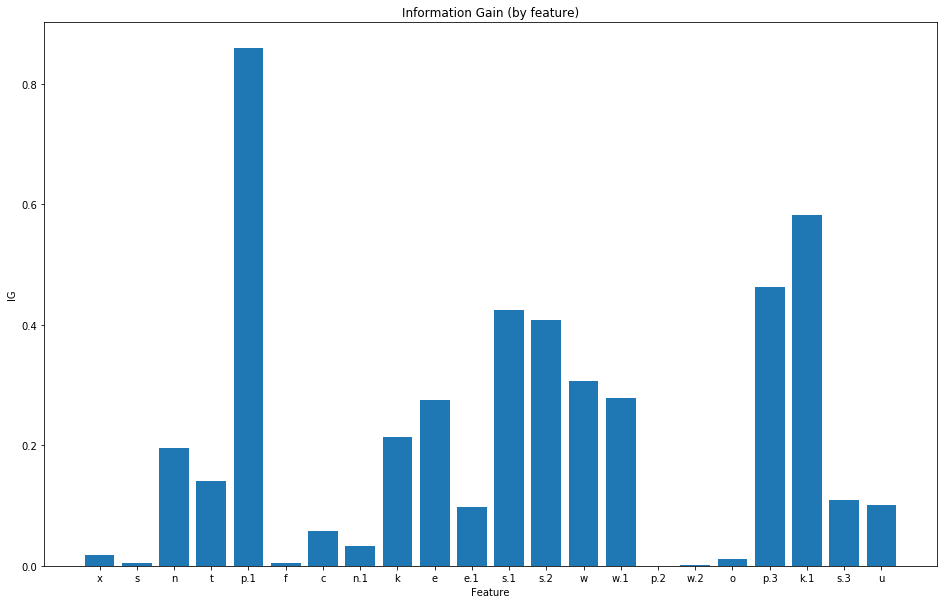

In [22]:
plt.ylabel('IG')
plt.xlabel('Feature')
plt.title('Information Gain (by feature)')
plt.bar(range(len(gains)), list(gains.values()), align='center')
plt.xticks(range(len(gains)), list(gains.keys()))
plt.show()

We can see that _p.1 (ODOR)_ provides the most information about the target. By selecting the top $k$ features according to the information gain they provide, we reduce the dimension of the data set from $d$ to $k$.